### Для начала загрузим наши данные(новости)

In [102]:
# pip install razdel - библиотека для токенизации текста(разбить текст на слова,предложения)
# pip install pymorphy2 - библиотека для лематизации текста( превращение слов в нормальные формы)

In [103]:
#!pip install pymorphy2
#!pip install razdel

In [104]:
import pandas as pd

In [105]:
news = pd.read_csv('articles.csv')
news.head()

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...
4,4899,Решением попечительского совета владивостокско...


Загрузим пользователей и списки последних прочитанных новостей

In [106]:
users = pd.read_csv('users_articles.csv')
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Для решения задачи

## 1. Получим векторные представления нашего текста

In [107]:
import re
import numpy as np
# natural language toolkit - обработка тексттов в рамках естественного языка
from nltk.corpus import stopwords
# В рамках разделов поднимает токенизацию
from razdel import tokenize
# Леммизация текста(стандартизация слов, подведение слов под их стандарты. Стандратное слово из множества словоформ)
import pymorphy2

In [108]:
# Подгружаем(обновляем) стоп-слова
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahhets\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [109]:
# Подгружаем русские стоп-слова
stopword_ru = stopwords.words('russian')

# Создаем объект для морфологического анализа(позволяет интерпретировать слова в нормальную форму)
morph = pymorphy2.MorphAnalyzer()

In [110]:
# Допустим, что данных стоп-слов не достаточно, тогда можно добавить свои стоп-слова
with open('stopwords.txt') as f:
    adittional_stopwords = [w.strip() for w in f.readlines()if w]
stopword_ru += adittional_stopwords

In [111]:
# Процедуры очистки текста
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str): # функция isinstance проверяет принадлежность экземпляра к классу
        text = str(text)
    
    text = text.lower() # делаем все буквы маленькими
    text = text.strip('\n').strip('\r').strip('\t') # удаляет начальные и конечные символы в строке
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text)) # re.sub ищет шаблон в подстроке и заменяет его на строку

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

# Лемматизация(еще есть стэмминг(попытается отбросить суффикс), процедура легкая, но грубая)
# Лемматизация превращает различные формы слов в меньшее кол-во вариантов этих слов с минимум потери смысловой нагрузки
def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text)) # Токенизация(разделяем текст на отдельные куски)
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6] Отделяем от стоп-слов
    
    return words_lem_without_stopwords

In [112]:
list(tokenize(news.iloc[0,1][:100])) # Тут мы посмотрели, как работает токенизатор

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [113]:
norm_text = news.iloc[:2,1].apply(lambda x: clean_text(x),1) # Очистка
norm_text

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [114]:
lemmatization(norm_text[0]) # Нормализация

['заместитель',
 'председатель',
 'правительство',
 'рф',
 'сергей',
 'иванов',
 'избрать',
 'председатель',
 'совет',
 'пбк',
 'цска',
 'сообщать',
 'прессслужба',
 'армеец',
 'решение',
 'единогласно',
 'принять',
 'первый',
 'заседание',
 'совет',
 'клуб',
 'основной',
 'функция',
 'это',
 'орган',
 'обсуждение',
 'текущий',
 'состояние',
 'планирование',
 'утверждение',
 'стратегия',
 'развитие',
 'клуб',
 'близкий',
 'перспектива',
 'состав',
 'совет',
 'войти',
 'георгий',
 'полтавченко',
 'полномочный',
 'представитель',
 'президент',
 'центральный',
 'федеральный',
 'округ',
 'алексей',
 'седов',
 'генералполковник',
 'начальник',
 'служба',
 'защита',
 'конституционный',
 'строй',
 'борьба',
 'терроризм',
 'фсб',
 'рф',
 'александр',
 'новак',
 'заместитель',
 'министр',
 'финансы',
 'рф',
 'вячеслав',
 'полтавец',
 'заместитель',
 'генеральный',
 'директор',
 'руководитель',
 'блок',
 'взаимодействие',
 'орган',
 'власть',
 'социальный',
 'корпоративный',
 'политика',
 'гмк',

In [115]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1) # Запустим очистку для всего документа

Wall time: 22.5 s


In [116]:
%%time
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1) # Запустим нормализацию(лемматизацию) для всего текста

Wall time: 2min 43s


#### Теперь обучим модель

In [117]:
# сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

In [118]:
# gensim - Тематическое моделирование — это метод извлечения основных тем которым посвящен обрабатываемый текст. 
# В пакете Gensim реализованы основные алгоритмы тематического моделирования LDA и LSI
from gensim.test.utils import common_texts
from gensim.corpora import Dictionary

In [119]:
# Создадим corpus из списка текста
# common dictipnary - 
common_dictionary = Dictionary(texts)
# корпус -  обычно представляет собой «собрание документов» в виде пакета слов или как его еще называют мешка слов!!!
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [120]:
common_dictionary.id2token # посмотреть на все индексы(токены) словаря

{}

In [121]:
common_dictionary.doc2bow(['баскетбол','баскетбол','наше','все'], allow_update=True)

[(5, 2), (135723, 1), (135724, 1)]

In [122]:
common_corpus[0][0] # СПАРС представление

(0, 2)

##### Словарь наших слов готов

### Построение LDA модели

In [123]:
"""Подход LDA к тематическому моделированию заключается в том,
что каждый документ рассматривается как набор тем в определенной пропорции. 
И каждая тема как набор ключевых слов, опять же, в определенной пропорции.

После того, как вы укажете алгоритму количество тем, все, 
что он сделает, — это отобразит распределение тем в документах и распределение ключевых слов по темам.

Тема — это не что иное, как набор доминирующих ключевых слов. 
Просто взглянув на ключевые слова, вы сможете определить, о чем эта тема."""
from gensim.models import LdaModel # импортируем саму модель

In [124]:
%%time
N_topic = 7 # это то, на сколько тем(предположительно) мы хотим разбить наш текст
# корпус - слова в спарс представлении
# id2word - сам словарь(где id сопоставлено определенному слову)
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)

Wall time: 19.5 s


Только что мы применили LDA прекобразование. Построили параметры для 7 Дирехле распределений,которые будут описывать нашу ситуацию. Теперь, опираясь на распределение, мы можем сказать какое место в пространстве наших тем занимает каждый конкретный текст

После построения модели мы получаем обученную модель, которую нужно интерпретировать

In [125]:
from gensim.test.utils import datapath
# Сохраним обученную модель на диск
temp_file = datapath('model.lda')
lda.save(temp_file)

In [126]:
# И загрузить
lda = LdaModel.load(temp_file)

Обучили модель словаря. Теперь 2 вопроса:
* Как выглядят наши темы
* Как получить для документа вектор значений(вероятности принадлежности каждой теме)

In [127]:
# Создадим новый корпус чтобы продемонстрировать работу нашей модели
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

In [128]:
# В итоге мы можем посмотреть на вектор с весами каждой темы для данного текста.
# К примеру lda[unseen_doc] = [(1, 0.44267473), (3, 0.5413114)]
# Это значит, что тема №1 имеет вес 0.44, а тема №3 имеет вес 0.54
# Можно сказать, что текст принадлежит двум темам из семи, при то к 3тьей теме относится больше
unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(2, 0.6778821), (5, 0.30583447)]

In [129]:
# Тут выведем по 7 слов из каждой темы. Слова естественно отвечают за свою тему
# Тоесть LDA выделил наиболее вероятностные слова для каждой темы
x=lda.show_topics(num_topics=25, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: погибнуть вода район высота км километр авария скорость пассажир ветер
topic_1: взрыв золото таиланд фестиваль автобус артист вследствие дания ожог золотой
topic_2: год который ракета это стать первый журнал луна свой самый
topic_3: год это который россия российский мочь компания время также тыс
topic_4: год россия который российский страна это проект новый программа также
topic_5: это который год человек мочь свой учёный россия всё весь
topic_6: человек год который полиция город сотрудник данные произойти также задержать


Большинство тем можно описать даже по такому кол-ву слов

#### Теперь нам нужно для каждого текста выстроить LDA-вектор

In [130]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text) # получили преобразование текста в id по нашему словарю(перестоили в bag of words)
    lda_tuple = lda[unseen_doc] # закинули это в LDA
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [131]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,6,0.000000,0.000000,0.101203,0.321492,0.000000,0.572085,0.0
1,4896,0.061716,0.102307,0.378026,0.447201,0.000000,0.000000,0.0
2,4897,0.000000,0.000000,0.677880,0.000000,0.000000,0.305836,0.0
3,4898,0.000000,0.000000,0.367690,0.000000,0.000000,0.623637,0.0
4,4899,0.095989,0.000000,0.080331,0.000000,0.302665,0.509010,0.0


Мы получили вектора наших новостей(doc_id) и умеем их интерпретировать(вероятности по topic)

### Теперь нам нужно векторно представить пользователей

In [132]:
users.head()

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [133]:
# построим соответствие id статей с конкретными векторами
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [134]:
doc_dict[1852]

array([0.04275699, 0.02076322, 0.        , 0.23923102, 0.03355885,
       0.27612299, 0.38721013])

In [135]:
# Пусть список статей, которые отвечают определенному пользователю будет сопоставлен с этим пользователем

user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    print(user_vector)
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [136]:
user_articles_list = users['articles'].iloc[33]

In [137]:
# Для конкретно нашего представления(который 6 статей прочитал) мы взяли и кажому id статьи сопоставили вектор темы, 
# который соответствует статье
# А далее мы найдем среднее по этим статьям, тем самым найдя средние вероятности тематических интересов пользователя
V = get_user_embedding(user_articles_list)

[[0.         0.         0.         0.         0.20063548 0.79287934
  0.        ]
 [0.         0.         0.21167612 0.36460721 0.41695046 0.
  0.        ]
 [0.         0.         0.06437308 0.         0.         0.80330414
  0.12832163]
 [0.         0.         0.         0.02743907 0.25666115 0.71180427
  0.        ]
 [0.         0.         0.         0.         0.         0.53193671
  0.45820719]
 [0.         0.         0.01144903 0.73016542 0.08991459 0.14154357
  0.02054956]]


In [138]:
# Вот он, вектор интересов пользователя в рамках статей
# К примеру он очень сильно интересовался 5 и 7 темами
V

array([0.        , 0.        , 0.04791637, 0.18703528, 0.16069361,
       0.49691134, 0.10117973])

In [139]:
import matplotlib.pyplot as plt

In [140]:
# Теперь каждому польвателю мы ставим в соответствие его тематический профиль(тоесть векторное представление)
# Это векторное представление называется эмбеддинг
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(3)

[[0.         0.         0.         0.454916   0.50215948 0.03317149
  0.        ]
 [0.         0.         0.5588392  0.14401796 0.16834545 0.11842275
  0.        ]
 [0.         0.         0.         0.3312721  0.54447591 0.10870913
  0.        ]
 [0.         0.         0.27770668 0.06030683 0.06285582 0.49766925
  0.09828737]
 [0.         0.         0.02287029 0.         0.23514114 0.73101282
  0.        ]
 [0.04275699 0.02076322 0.         0.23923102 0.03355885 0.27612299
  0.38721013]]
[[0.         0.         0.         0.09745692 0.         0.57941067
  0.32194898]
 [0.         0.01201168 0.07849616 0.06005405 0.0959896  0.75202429
  0.        ]
 [0.0519074  0.         0.         0.54580587 0.08339705 0.23240718
  0.08580652]
 [0.         0.         0.14415318 0.07461415 0.10197428 0.67825937
  0.        ]
 [0.         0.         0.06145509 0.03966033 0.         0.8597194
  0.02999661]
 [0.         0.         0.         0.24916644 0.         0.74499327
  0.        ]]
[[0.3311235  0.

  0.10020773]]
[[0.         0.         0.32469067 0.02713182 0.42740476 0.
  0.21180902]
 [0.         0.         0.         0.06923166 0.68122131 0.24354091
  0.        ]
 [0.         0.         0.3710658  0.         0.         0.61674428
  0.        ]
 [0.         0.         0.         0.50534201 0.21354826 0.2741085
  0.        ]
 [0.         0.         0.47495857 0.47141278 0.04603514 0.
  0.        ]
 [0.         0.         0.02694851 0.22576159 0.13748445 0.60923606
  0.        ]]
[[0.         0.         0.82749927 0.10509031 0.         0.06281467
  0.        ]
 [0.14765947 0.         0.3150014  0.25485632 0.11206742 0.15891461
  0.        ]
 [0.         0.         0.         0.66238892 0.25509778 0.07474504
  0.        ]
 [0.17524225 0.         0.29595774 0.41612029 0.         0.1069414
  0.        ]
 [0.01931224 0.         0.         0.18504773 0.7882722  0.
  0.        ]
 [0.         0.         0.01424051 0.11665352 0.         0.46549264
  0.40262946]]
[[0.05685519 0.         0

  0.02357861]]
[[0.         0.         0.0243144  0.         0.         0.75141823
  0.21573102]
 [0.         0.         0.         0.04127605 0.25334072 0.7003063
  0.        ]
 [0.         0.         0.         0.093591   0.04311563 0.50754195
  0.35204709]
 [0.01933476 0.         0.         0.         0.07895403 0.71164131
  0.1854919 ]
 [0.         0.         0.         0.24318139 0.         0.48936757
  0.26278269]
 [0.         0.         0.0528206  0.70531458 0.12499622 0.11214568
  0.        ]]
[[0.         0.         0.         0.07747722 0.02734848 0.75330514
  0.13983659]
 [0.         0.         0.         0.05263841 0.         0.74795169
  0.19336699]
 [0.03367193 0.         0.         0.36483818 0.         0.12979199
  0.46737301]
 [0.         0.         0.         0.49544069 0.18679644 0.
  0.30375215]
 [0.         0.         0.07952687 0.28360018 0.         0.24042559
  0.38844961]
 [0.         0.         0.         0.81299704 0.         0.
  0.17174841]]
[[0.         0. 

  0.        ]]
[[0.         0.06161382 0.42649171 0.         0.         0.50545919
  0.        ]
 [0.         0.         0.97726178 0.         0.         0.
  0.        ]
 [0.03367209 0.06498558 0.37766337 0.34349766 0.         0.17735128
  0.        ]
 [0.         0.         0.49094716 0.         0.13404126 0.36282447
  0.        ]
 [0.05248998 0.         0.34318426 0.         0.         0.5966965
  0.        ]
 [0.18876252 0.         0.06506331 0.18412228 0.12442351 0.43689013
  0.        ]]
[[0.         0.         0.         0.         0.39339441 0.59905088
  0.        ]
 [0.         0.         0.         0.74685854 0.09304958 0.12810743
  0.0297267 ]
 [0.         0.         0.         0.74550503 0.20642045 0.04228469
  0.        ]
 [0.02129254 0.02284063 0.         0.05291549 0.         0.13242967
  0.76799834]
 [0.         0.         0.         0.18425958 0.06362032 0.6540308
  0.09304541]
 [0.08449805 0.         0.         0.62528473 0.17161131 0.11674068
  0.        ]]
[[0.     

  0.        ]]
[[0.         0.         0.         0.15714985 0.         0.8327837
  0.        ]
 [0.         0.         0.         0.39845198 0.10032585 0.49667278
  0.        ]
 [0.02055312 0.         0.         0.         0.0833222  0.41794011
  0.47239155]
 [0.04185479 0.         0.03219229 0.         0.38188329 0.38259396
  0.15940003]
 [0.         0.         0.         0.05548705 0.11276365 0.82852387
  0.        ]
 [0.         0.         0.15896887 0.23435313 0.42408359 0.17966208
  0.        ]]
[[0.         0.         0.         0.1198796  0.04337068 0.673778
  0.15756541]
 [0.0831667  0.         0.         0.0883794  0.03829546 0.23900153
  0.55043834]
 [0.         0.         0.04740033 0.12426595 0.         0.65870899
  0.1645806 ]
 [0.38979593 0.         0.         0.19229041 0.10238744 0.15997216
  0.1550339 ]
 [0.01480922 0.         0.34839022 0.15129551 0.06642994 0.40068719
  0.01824273]
 [0.         0.         0.57285231 0.         0.14982386 0.27236101
  0.        ]]
[[

  0.        ]]
[[0.23560524 0.         0.65051258 0.         0.09815939 0.
  0.        ]
 [0.         0.         0.10584345 0.         0.28841779 0.28150305
  0.31838074]
 [0.         0.         0.         0.79808766 0.19513315 0.
  0.        ]
 [0.         0.         0.07882381 0.3164233  0.60184169 0.
  0.        ]
 [0.         0.         0.28571519 0.         0.3284018  0.37503824
  0.        ]
 [0.         0.         0.         0.5650003  0.15175822 0.21235582
  0.06990982]]
[[0.17992596 0.10750102 0.17884581 0.         0.         0.52803189
  0.        ]
 [0.08328266 0.45501131 0.         0.         0.44762096 0.
  0.        ]
 [0.         0.         0.7246244  0.         0.24893783 0.
  0.        ]
 [0.         0.         0.43406516 0.         0.         0.55683404
  0.        ]
 [0.         0.         0.60022038 0.         0.         0.3812826
  0.        ]
 [0.         0.01995573 0.34163979 0.1188877  0.         0.51815534
  0.        ]]
[[0.         0.         0.77530921 0.   

  0.22674197]]
[[0.10811424 0.         0.42017499 0.17115329 0.18665223 0.10815663
  0.        ]
 [0.         0.         0.01375637 0.201942   0.11428942 0.34702167
  0.32015046]
 [0.         0.         0.53863651 0.03439459 0.         0.42103747
  0.        ]
 [0.         0.         0.         0.37063706 0.46767378 0.
  0.15566723]
 [0.         0.         0.         0.08205437 0.46694949 0.40931374
  0.03388223]
 [0.         0.         0.12046242 0.59581691 0.24679631 0.031279
  0.        ]]
[[0.         0.         0.07552972 0.0569721  0.         0.86265105
  0.        ]
 [0.0120216  0.         0.04430764 0.07976395 0.01325948 0.8500793
  0.        ]
 [0.         0.         0.04619398 0.33401418 0.01462744 0.32619324
  0.27830604]
 [0.         0.         0.         0.06342336 0.02838596 0.66737252
  0.23985209]
 [0.1994227  0.         0.03221374 0.16164668 0.13206792 0.2516655
  0.22265351]
 [0.         0.         0.         0.0730379  0.05649692 0.86713147
  0.        ]]
[[0.       

  0.02401748]]
[[0.         0.01321721 0.09332409 0.12264182 0.35761651 0.41286334
  0.        ]
 [0.         0.         0.         0.11483618 0.40505078 0.43526623
  0.04400906]
 [0.         0.01936846 0.04927801 0.70817244 0.06435025 0.15528317
  0.        ]
 [0.03471571 0.02914819 0.         0.04473275 0.0964457  0.3951019
  0.39949191]
 [0.02028234 0.         0.         0.07369374 0.10254119 0.63362855
  0.16916545]
 [0.         0.         0.         0.         0.09134923 0.90380925
  0.        ]]
[[0.         0.         0.         0.07615838 0.1523221  0.77025199
  0.        ]
 [0.         0.         0.03280204 0.04530404 0.         0.71264762
  0.20529035]
 [0.28334269 0.         0.16663057 0.14492796 0.31409493 0.09048465
  0.        ]
 [0.15746447 0.         0.18658029 0.19344947 0.         0.390479
  0.07133944]
 [0.01006966 0.         0.25834736 0.04015996 0.         0.30954406
  0.38119942]
 [0.         0.         0.         0.         0.39366594 0.49380475
  0.10659811]]
[[

  0.        ]]
[[0.03884862 0.         0.49858031 0.0522497  0.         0.15272312
  0.2529889 ]
 [0.         0.         0.05788536 0.25737989 0.39335638 0.28176278
  0.        ]
 [0.         0.         0.63083524 0.         0.         0.20762981
  0.14410585]
 [0.01578018 0.01241061 0.54213661 0.22548416 0.20137183 0.
  0.        ]
 [0.08284988 0.01494532 0.52559137 0.         0.         0.36776909
  0.        ]
 [0.         0.         0.14433642 0.27281272 0.08050972 0.38598558
  0.11598216]]
[[0.         0.         0.         0.07807724 0.         0.81401169
  0.09942371]
 [0.0127251  0.         0.0341125  0.11916957 0.01538742 0.59558755
  0.22288024]
 [0.04408102 0.         0.07449526 0.14771028 0.02380406 0.70930463
  0.        ]
 [0.         0.         0.01729917 0.21439923 0.         0.50453424
  0.25506267]
 [0.         0.         0.         0.53985435 0.01640912 0.3492668
  0.08340796]
 [0.         0.         0.         0.07961453 0.         0.90555561
  0.        ]]
[[0.    

  0.        ]]
[[0.         0.         0.         0.         0.75639147 0.23125902
  0.        ]
 [0.         0.         0.         0.         0.12282962 0.87300307
  0.        ]
 [0.02568009 0.         0.         0.32140362 0.64041686 0.
  0.        ]
 [0.         0.         0.15949513 0.         0.         0.52854604
  0.30346501]
 [0.         0.         0.         0.         0.10730367 0.77971512
  0.10823751]
 [0.         0.         0.23292524 0.28496194 0.35571197 0.12278949
  0.        ]]
[[0.         0.         0.         0.         0.         0.70565879
  0.28558469]
 [0.04005264 0.         0.         0.35370865 0.40063187 0.20234562
  0.        ]
 [0.         0.         0.         0.         0.31705344 0.67522466
  0.        ]
 [0.         0.         0.         0.01262867 0.         0.86570096
  0.11952642]
 [0.         0.         0.         0.07490895 0.         0.42020345
  0.49457824]
 [0.         0.         0.05553452 0.24056515 0.17007053 0.20819944
  0.32185274]]
[[0.   

  0.17969146]]
[[0.         0.         0.         0.         0.97672772 0.
  0.        ]
 [0.         0.         0.         0.55205065 0.         0.19340508
  0.25130263]
 [0.         0.         0.         0.         0.29888326 0.69614261
  0.        ]
 [0.         0.         0.04913634 0.25344935 0.         0.69049501
  0.        ]
 [0.         0.         0.01721242 0.         0.06085828 0.91533846
  0.        ]
 [0.         0.         0.13890204 0.16125926 0.50808871 0.
  0.18418556]]
[[0.35078108 0.01672285 0.05836807 0.12928319 0.05409228 0.25663337
  0.13411915]
 [0.01188146 0.         0.09440853 0.         0.38455394 0.50168943
  0.        ]
 [0.22185823 0.         0.0157018  0.42020527 0.14440851 0.
  0.19698077]
 [0.01312185 0.         0.05641622 0.26137713 0.         0.41020474
  0.25809452]
 [0.06802511 0.         0.         0.34229195 0.13028972 0.22776876
  0.23088601]
 [0.         0.         0.         0.34021616 0.05308431 0.45077166
  0.15328924]]
[[0.         0.        

  0.        ]]
[[0.         0.         0.36877757 0.         0.18302293 0.44242007
  0.        ]
 [0.         0.         0.         0.         0.         0.6477617
  0.34620884]
 [0.04773157 0.         0.         0.03170152 0.         0.09514334
  0.81840098]
 [0.         0.         0.         0.         0.35748136 0.40446645
  0.23386236]
 [0.         0.         0.         0.64066613 0.         0.34366196
  0.01219706]
 [0.         0.         0.         0.22809537 0.75502867 0.
  0.        ]]
[[0.         0.         0.         0.02912257 0.38340294 0.58172786
  0.        ]
 [0.         0.         0.         0.0713993  0.05494001 0.67299348
  0.1991363 ]
 [0.         0.         0.22035615 0.         0.         0.75112325
  0.02211791]
 [0.         0.         0.         0.         0.6853177  0.30653539
  0.        ]
 [0.         0.         0.         0.         0.94541192 0.04656004
  0.        ]
 [0.31152588 0.         0.07802785 0.04418162 0.04313814 0.45267549
  0.0701284 ]]
[[0.    

  0.23235875]]
[[0.         0.         0.27845216 0.         0.09607745 0.61392009
  0.        ]
 [0.         0.         0.60723025 0.03938727 0.         0.34299287
  0.        ]
 [0.         0.06653153 0.0794194  0.         0.58387148 0.26769903
  0.        ]
 [0.         0.         0.35967624 0.43763316 0.         0.18662143
  0.        ]
 [0.         0.         0.44759768 0.         0.4212341  0.11911563
  0.        ]
 [0.06602882 0.         0.04458832 0.20256774 0.         0.6297645
  0.05628666]]
[[0.         0.         0.5127027  0.         0.02334293 0.4588016
  0.        ]
 [0.         0.31728742 0.24818695 0.         0.36547312 0.0583992
  0.        ]
 [0.         0.         0.67879623 0.         0.29360601 0.
  0.        ]
 [0.         0.         0.44625235 0.         0.         0.54335105
  0.        ]
 [0.0548258  0.11119778 0.71956253 0.         0.         0.10789844
  0.        ]
 [0.10309084 0.         0.33785984 0.31264597 0.24242353 0.
  0.        ]]
[[0.         0.   

  0.        ]]
[[0.         0.         0.02336253 0.03757307 0.63545156 0.0844302
  0.21655096]
 [0.         0.         0.         0.28895235 0.70646155 0.
  0.        ]
 [0.05238447 0.         0.         0.67095733 0.26539516 0.
  0.        ]
 [0.         0.         0.         0.11379666 0.         0.64983797
  0.23077598]
 [0.         0.         0.         0.01888704 0.27089596 0.65591431
  0.05149974]
 [0.         0.06587519 0.         0.154568   0.35708919 0.41728184
  0.        ]]
[[0.         0.         0.         0.13001627 0.         0.38891837
  0.47274035]
 [0.0270544  0.         0.30057666 0.         0.         0.66576517
  0.        ]
 [0.         0.         0.02685888 0.44579357 0.14188139 0.36632738
  0.01735949]
 [0.         0.         0.         0.1656068  0.25881156 0.42437094
  0.14703786]
 [0.         0.         0.01345058 0.33003783 0.30190843 0.
  0.35116589]
 [0.17074744 0.         0.         0.50133151 0.32230708 0.
  0.        ]]
[[0.         0.         0.      

  0.        ]]
[[0.         0.         0.42641962 0.         0.         0.56706512
  0.        ]
 [0.         0.         0.61831051 0.31085044 0.         0.06020569
  0.        ]
 [0.17451918 0.69533515 0.         0.         0.         0.05707151
  0.06407505]
 [0.         0.         0.53849262 0.         0.         0.44610459
  0.        ]
 [0.         0.07536087 0.40825823 0.         0.         0.50469524
  0.        ]
 [0.         0.         0.01967946 0.22443746 0.31914231 0.43618736
  0.        ]]
[[0.         0.         0.20309046 0.11041021 0.58515543 0.09966838
  0.        ]
 [0.         0.         0.31123593 0.1785548  0.         0.50235134
  0.        ]
 [0.         0.         0.61891234 0.14403012 0.         0.10592976
  0.11885903]
 [0.         0.         0.39215654 0.53237253 0.         0.
  0.06085721]
 [0.         0.         0.0590944  0.13022417 0.22251181 0.40639147
  0.17872825]
 [0.         0.         0.02173948 0.2853398  0.30213422 0.38458139
  0.        ]]
[[0.   

  0.        ]]
[[0.         0.         0.06164081 0.36076522 0.         0.51078832
  0.0632786 ]
 [0.         0.         0.         0.         0.         0.98985231
  0.        ]
 [0.         0.         0.         0.         0.51016629 0.48015395
  0.        ]
 [0.         0.         0.         0.17963257 0.24698488 0.25044933
  0.31741688]
 [0.         0.         0.         0.03810247 0.36243099 0.59481204
  0.        ]
 [0.12261141 0.         0.         0.19576043 0.63284343 0.04114142
  0.        ]]
[[0.06136512 0.         0.         0.04882738 0.         0.38299927
  0.4996379 ]
 [0.         0.         0.01424677 0.03389904 0.25524753 0.69364035
  0.        ]
 [0.         0.         0.11882287 0.32318351 0.12343099 0.28198844
  0.15107955]
 [0.         0.         0.37234479 0.11201078 0.         0.44607526
  0.06778589]
 [0.         0.         0.         0.24294753 0.         0.64410293
  0.10869479]
 [0.         0.         0.12838215 0.30224442 0.47014552 0.08759866
  0.        ]]

[[0.         0.         0.0446543  0.02769327 0.01119905 0.91342467
  0.        ]
 [0.01442834 0.         0.         0.12453588 0.10444701 0.65279055
  0.10248196]
 [0.03481744 0.         0.         0.         0.07318889 0.77617532
  0.11113968]
 [0.         0.         0.         0.07114818 0.30977547 0.59729242
  0.01914385]
 [0.         0.         0.         0.05451482 0.11219378 0.83052313
  0.        ]
 [0.         0.         0.         0.43996915 0.33944532 0.21603388
  0.        ]]
[[0.         0.         0.07952687 0.28360018 0.         0.24042559
  0.38844961]
 [0.         0.         0.         0.09156308 0.         0.06541953
  0.83290201]
 [0.         0.         0.         0.04323545 0.48912269 0.46319789
  0.        ]
 [0.         0.         0.02985586 0.         0.20256615 0.42066953
  0.34212708]
 [0.         0.         0.04158431 0.17655033 0.09932114 0.55224133
  0.12612192]
 [0.45701063 0.02903841 0.04253576 0.18174405 0.08627472 0.10546102
  0.09793538]]
[[0.         0

  0.49206126]]
[[0.         0.         0.98446596 0.         0.         0.
  0.        ]
 [0.29109046 0.37026471 0.22686704 0.         0.10201279 0.
  0.        ]
 [0.         0.74964982 0.         0.         0.23232298 0.
  0.        ]
 [0.         0.         0.55856627 0.         0.         0.42866302
  0.        ]
 [0.02827364 0.09752733 0.86176771 0.         0.         0.
  0.        ]
 [0.         0.         0.         0.47851917 0.22633271 0.28807002
  0.        ]]
[[0.         0.         0.04039346 0.70250219 0.24812454 0.
  0.        ]
 [0.         0.         0.         0.27452487 0.         0.71980292
  0.        ]
 [0.         0.         0.15393622 0.         0.         0.78501236
  0.05492542]
 [0.         0.         0.         0.         0.         0.69846648
  0.29057491]
 [0.         0.         0.         0.         0.20063548 0.79287934
  0.        ]
 [0.12719908 0.         0.03053894 0.40417793 0.22709303 0.20636709
  0.        ]]
[[0.         0.         0.14620067 0.15

  0.        ]]
[[0.         0.         0.04708873 0.         0.         0.
  0.93036908]
 [0.23775575 0.         0.1283628  0.1135702  0.         0.26055771
  0.25389713]
 [0.         0.         0.16677128 0.31549537 0.         0.51158988
  0.        ]
 [0.         0.         0.         0.         0.05917534 0.89611566
  0.03912416]
 [0.         0.         0.21826325 0.07890803 0.         0.58993673
  0.10792448]
 [0.         0.         0.40624002 0.10493711 0.47906986 0.
  0.        ]]
[[0.         0.         0.         0.18929385 0.         0.48293293
  0.32231691]
 [0.32803625 0.         0.         0.32811958 0.26891702 0.07120994
  0.        ]
 [0.         0.         0.20300002 0.07019506 0.1059917  0.61866897
  0.        ]
 [0.         0.         0.15799424 0.04109195 0.21715619 0.58097816
  0.        ]
 [0.         0.         0.01339739 0.28799149 0.         0.69487709
  0.        ]
 [0.         0.         0.16609009 0.2812883  0.02766541 0.52327108
  0.        ]]
[[0.         0.

  0.        ]]
[[0.         0.         0.         0.         0.17021084 0.82450223
  0.        ]
 [0.         0.         0.         0.         0.         0.76420927
  0.22795923]
 [0.         0.         0.66267997 0.         0.20928454 0.11724282
  0.        ]
 [0.         0.         0.10852474 0.         0.         0.55919796
  0.3195065 ]
 [0.         0.         0.         0.         0.25395021 0.73448199
  0.        ]
 [0.         0.         0.         0.15108532 0.07052472 0.74669325
  0.02969554]]
[[0.         0.         0.         0.53264242 0.         0.31557107
  0.14661899]
 [0.         0.         0.         0.         0.18350476 0.79456156
  0.01803235]
 [0.         0.         0.         0.         0.16714948 0.51905894
  0.30913964]
 [0.         0.         0.20300002 0.07019506 0.1059917  0.61866897
  0.        ]
 [0.         0.         0.         0.         0.         0.90484017
  0.08569565]
 [0.08073916 0.         0.11509553 0.52801764 0.01874536 0.
  0.25066084]]
[[0.   

  0.40152398]]
[[0.         0.         0.         0.         0.28728139 0.70723718
  0.        ]
 [0.0293822  0.         0.         0.         0.04170767 0.28611645
  0.63484883]
 [0.         0.         0.13386534 0.         0.42234483 0.43946764
  0.        ]
 [0.         0.         0.27695018 0.16519937 0.         0.48900595
  0.06511503]
 [0.         0.         0.         0.08534156 0.         0.54096133
  0.36861628]
 [0.23119104 0.         0.10569315 0.12987235 0.06418043 0.19541506
  0.27194181]]
[[0.         0.         0.         0.22459807 0.38639551 0.19793296
  0.1878435 ]
 [0.01381238 0.         0.         0.19231543 0.         0.72562081
  0.06418677]
 [0.         0.         0.         0.47900689 0.         0.13077012
  0.3714703 ]
 [0.07096928 0.         0.         0.19004817 0.         0.13539265
  0.59642792]
 [0.         0.         0.         0.12257505 0.15523815 0.5678792
  0.15074076]
 [0.         0.         0.         0.         0.82497281 0.16677529
  0.        ]]


  0.        ]]
[[0.         0.         0.2838082  0.         0.         0.69233984
  0.        ]
 [0.         0.         0.4134402  0.         0.         0.57237059
  0.        ]
 [0.32326305 0.23448519 0.42636207 0.         0.         0.
  0.        ]
 [0.27240181 0.61757249 0.         0.         0.09636986 0.
  0.        ]
 [0.         0.03351668 0.68564582 0.         0.         0.26834327
  0.        ]
 [0.1172113  0.         0.20687839 0.37412086 0.         0.30083609
  0.        ]]
[[0.17646247 0.06023412 0.2357569  0.         0.         0.52351528
  0.        ]
 [0.         0.         0.70050102 0.         0.         0.28151655
  0.        ]
 [0.         0.         0.5101974  0.20454985 0.         0.2755039
  0.        ]
 [0.         0.         0.93118781 0.         0.04634036 0.
  0.        ]
 [0.18547772 0.67952907 0.12423852 0.         0.         0.
  0.        ]
 [0.         0.         0.3127048  0.18177246 0.         0.50030202
  0.        ]]
[[0.         0.         0.      

  0.34674317]]
[[0.         0.         0.29998586 0.03947553 0.06198911 0.59491956
  0.        ]
 [0.         0.         0.         0.03063241 0.         0.73568779
  0.22553393]
 [0.03113788 0.         0.         0.         0.         0.52016145
  0.44092169]
 [0.01509405 0.         0.         0.6856944  0.07210723 0.16464251
  0.06011271]
 [0.         0.         0.01339739 0.28799149 0.         0.69487709
  0.        ]
 [0.         0.         0.         0.16577081 0.         0.50243807
  0.32564583]]
[[0.         0.         0.         0.26527441 0.1055701  0.14344986
  0.48053917]
 [0.         0.         0.12344315 0.03775692 0.17356606 0.56194037
  0.10021458]
 [0.         0.         0.         0.86560237 0.         0.08336157
  0.03976263]
 [0.         0.         0.         0.1269528  0.         0.86406922
  0.        ]
 [0.         0.         0.06148475 0.26160842 0.         0.29407385
  0.37858436]
 [0.         0.         0.         0.75699955 0.         0.22982444
  0.        ]]

  0.        ]]
[[0.03026393 0.         0.         0.04399952 0.         0.30754316
  0.61340791]
 [0.         0.         0.         0.         0.19287555 0.79455525
  0.        ]
 [0.         0.         0.         0.12660135 0.34237042 0.51933026
  0.        ]
 [0.         0.         0.23880927 0.23324935 0.2893835  0.23638137
  0.        ]
 [0.         0.         0.         0.03324553 0.         0.63936216
  0.32056949]
 [0.11218031 0.         0.11316835 0.53122854 0.09309315 0.14961313
  0.        ]]
[[0.         0.         0.         0.         0.         0.62421322
  0.36266217]
 [0.         0.         0.         0.15862304 0.         0.58016777
  0.25564772]
 [0.         0.         0.02385351 0.24817477 0.08037652 0.64076054
  0.        ]
 [0.         0.         0.         0.         0.12682782 0.33457586
  0.53585756]
 [0.         0.         0.         0.03443868 0.90615422 0.03358653
  0.02202495]
 [0.         0.06445682 0.         0.         0.75924915 0.10538707
  0.06531221]]

[[0.02309983 0.01146595 0.         0.37818    0.09149681 0.25816995
  0.23611942]
 [0.02690029 0.         0.         0.14343849 0.         0.50760156
  0.31957245]
 [0.01090339 0.         0.         0.         0.4368799  0.54710323
  0.        ]
 [0.         0.         0.10674751 0.         0.35382026 0.44424969
  0.08822525]
 [0.         0.         0.         0.02419654 0.01934788 0.83603138
  0.11757606]
 [0.         0.         0.30092758 0.01695011 0.41648886 0.16609234
  0.09579993]]
[[0.         0.01221508 0.26890212 0.36581436 0.03478022 0.31607139
  0.        ]
 [0.         0.         0.50083685 0.         0.         0.48783335
  0.        ]
 [0.         0.         0.76351923 0.12102582 0.09676342 0.
  0.        ]
 [0.         0.60277647 0.14078927 0.         0.20288612 0.
  0.04473975]
 [0.09016314 0.         0.36436793 0.04722144 0.         0.49283579
  0.        ]
 [0.06090266 0.         0.25759399 0.11120306 0.         0.55099869
  0.01847631]]
[[0.         0.         0.    

  0.15745574]]
[[0.         0.         0.30408671 0.         0.         0.68681246
  0.        ]
 [0.09712081 0.         0.         0.18056348 0.0363701  0.11293797
  0.5703693 ]
 [0.         0.         0.         0.11312755 0.07796421 0.80540675
  0.        ]
 [0.         0.         0.03289593 0.15278047 0.08263882 0.72924858
  0.        ]
 [0.08461878 0.         0.2800062  0.06452709 0.         0.51295912
  0.05649635]
 [0.03035669 0.         0.04208018 0.20504725 0.04632108 0.63362116
  0.04230131]]
[[0.         0.04936878 0.34441847 0.         0.59509689 0.
  0.        ]
 [0.37387919 0.60756034 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.74791628 0.23708168 0.         0.
  0.        ]
 [0.         0.         0.76675105 0.         0.21457572 0.
  0.        ]
 [0.         0.         0.20105952 0.23273186 0.33378893 0.22566645
  0.        ]
 [0.07856537 0.         0.30608931 0.59192699 0.         0.02156082
  0.        ]]
[[0.         0.         0.     

  0.04299426]]
[[0.         0.         0.21517219 0.51968384 0.         0.10318031
  0.15702622]
 [0.         0.         0.13179581 0.23751006 0.62183326 0.
  0.        ]
 [0.02992591 0.         0.         0.15015428 0.80813271 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.92156941
  0.06907827]
 [0.         0.         0.         0.24115045 0.45080343 0.30197886
  0.        ]
 [0.35340533 0.         0.08098803 0.02901274 0.30324692 0.23282772
  0.        ]]
[[0.         0.         0.65768212 0.         0.31157061 0.
  0.        ]
 [0.         0.57712847 0.         0.         0.28252715 0.12908849
  0.        ]
 [0.         0.         0.51889783 0.         0.06017751 0.34477666
  0.06686355]
 [0.         0.         0.61402738 0.         0.         0.37754554
  0.        ]
 [0.27402365 0.43518206 0.         0.         0.27180642 0.
  0.        ]
 [0.03930675 0.         0.19553797 0.04337365 0.04549455 0.2588256
  0.41709718]]
[[0.10175111 0.         0.643395

[[0.         0.         0.         0.04965132 0.93630868 0.
  0.        ]
 [0.         0.         0.48857209 0.14544262 0.         0.35750514
  0.        ]
 [0.         0.         0.51394373 0.         0.         0.34616444
  0.13202533]
 [0.         0.         0.55197001 0.04813317 0.         0.20793749
  0.17912313]
 [0.         0.         0.03049    0.58199877 0.36025673 0.02305412
  0.        ]
 [0.03198918 0.         0.14438386 0.02475462 0.         0.52295268
  0.26962471]]
[[0.         0.         0.68330014 0.29787508 0.         0.
  0.        ]
 [0.18701127 0.06702266 0.15877976 0.03690128 0.         0.54776829
  0.        ]
 [0.         0.         0.23971553 0.13172804 0.61894345 0.
  0.        ]
 [0.         0.         0.55338013 0.         0.         0.43886822
  0.        ]
 [0.         0.         0.54756612 0.         0.         0.44714409
  0.        ]
 [0.05141473 0.         0.47859651 0.25162527 0.         0.21606115
  0.        ]]
[[0.         0.         0.         0. 

  0.01317528]]
[[0.         0.         0.07714418 0.         0.         0.85489148
  0.06343325]
 [0.03981882 0.         0.02966326 0.47582123 0.         0.
  0.45051473]
 [0.         0.         0.02007304 0.53146189 0.19605894 0.11737557
  0.13301952]
 [0.         0.         0.         0.         0.         0.36605147
  0.62840724]
 [0.         0.         0.06235642 0.         0.53616446 0.39661691
  0.        ]
 [0.03499545 0.         0.         0.0885306  0.         0.82586229
  0.03885991]]
[[0.09644879 0.         0.02153127 0.25657907 0.09836786 0.5229494
  0.        ]
 [0.         0.         0.         0.75580961 0.         0.23639704
  0.        ]
 [0.19547495 0.         0.         0.47635993 0.         0.
  0.32396612]
 [0.05918707 0.         0.         0.10880906 0.         0.49305281
  0.3349193 ]
 [0.         0.         0.         0.5856787  0.         0.28351092
  0.12515745]
 [0.         0.         0.03103848 0.37751457 0.09847453 0.48456866
  0.        ]]
[[0.16530862 0. 

  0.        ]]
[[0.         0.         0.         0.21962997 0.37926376 0.36939752
  0.02665481]
 [0.         0.01119114 0.         0.59436649 0.38848296 0.
  0.        ]
 [0.         0.         0.37586588 0.         0.         0.6145528
  0.        ]
 [0.         0.         0.73370278 0.07060798 0.         0.16226664
  0.02612715]
 [0.         0.         0.48707491 0.12181125 0.05703104 0.32452792
  0.        ]
 [0.18543077 0.         0.         0.28550154 0.         0.19637024
  0.33172801]]
[[0.         0.         0.         0.22983813 0.13115445 0.33117729
  0.30449674]
 [0.         0.         0.         0.         0.         0.57957655
  0.41530234]
 [0.         0.02633288 0.         0.08636437 0.         0.33591655
  0.54182571]
 [0.         0.         0.         0.         0.02082795 0.97617763
  0.        ]
 [0.         0.         0.         0.         0.         0.64643532
  0.34727526]
 [0.05243255 0.03112717 0.         0.13928746 0.         0.42833513
  0.34812856]]
[[0.    

[[0.         0.         0.1667935  0.16379037 0.         0.46861956
  0.19727996]
 [0.         0.         0.15799424 0.04109195 0.21715619 0.58097816
  0.        ]
 [0.02103077 0.         0.03887947 0.02956723 0.06167654 0.84684771
  0.        ]
 [0.01440342 0.         0.         0.27028707 0.04213407 0.60947984
  0.06053806]
 [0.         0.         0.         0.07173055 0.28873163 0.63410187
  0.        ]
 [0.0915546  0.         0.05254335 0.52722353 0.12396178 0.
  0.19843875]]
[[0.         0.         0.         0.03339684 0.57420665 0.39109528
  0.        ]
 [0.02345841 0.         0.07129629 0.19024274 0.13025495 0.49271208
  0.09166834]
 [0.         0.         0.02741604 0.27864301 0.03394293 0.65958458
  0.        ]
 [0.01495791 0.         0.         0.07130527 0.         0.55975711
  0.35315803]
 [0.         0.         0.         0.0920721  0.         0.50895506
  0.39530057]
 [0.         0.         0.         0.31535873 0.         0.34820485
  0.33238423]]
[[0.         0.       

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[[0.         0.         0.         0.         0.64909267 0.23350835
  0.1037099 ]
 [0.0689058  0.         0.62800384 0.         0.0651162  0.13240568
  0.10141429]
 [0.         0.         0.73351908 0.         0.05668154 0.19571358
  0.        ]
 [0.         0.         0.36228761 0.12736869 0.49526328 0.
  0.        ]
 [0.         0.         0.73203444 0.11561449 0.03894241 0.1017682
  0.        ]
 [0.06506209 0.         0.12182038 0.03730238 0.02152545 0.20289813
  0.54809564]]
[[0.         0.         0.         0.05263841 0.         0.74795169
  0.19336699]
 [0.         0.         0.         0.         0.50920862 0.48226169
  0.        ]
 [0.         0.         0.35383976 0.13022578 0.14632314 0.36415762
  0.        ]
 [0.         0.         0.01495883 0.         0.69001013 0.28879899
  0.        ]
 [0.         0.         0.08759657 0.         0.89449555 0.
  0.        ]
 [0.1476579  0.         0.01489394 0.59774041 0.12787935 0.02300425
  0.08851477]]
[[0.         0.         0.2665

  0.        ]]
[[0.03196986 0.06751903 0.0737142  0.09076048 0.05758544 0.3843641
  0.2940869 ]
 [0.21905366 0.         0.01494615 0.38260099 0.12426759 0.20103812
  0.05788964]
 [0.14094426 0.         0.         0.17254595 0.         0.37277842
  0.30357915]
 [0.         0.         0.         0.18679784 0.02068075 0.71424866
  0.0761891 ]
 [0.         0.         0.03751412 0.22664152 0.13475671 0.53812701
  0.0622652 ]
 [0.         0.         0.04039346 0.70250219 0.24812454 0.
  0.        ]]
[[0.01632594 0.         0.35559821 0.21277864 0.13914524 0.24388346
  0.03210626]
 [0.17435595 0.         0.17779258 0.12425888 0.         0.25438616
  0.26870355]
 [0.01865987 0.         0.0296228  0.18926498 0.         0.63966554
  0.12213287]
 [0.         0.         0.         0.18744844 0.08199915 0.39359587
  0.33579013]
 [0.         0.         0.21025553 0.34368533 0.14291635 0.27504343
  0.02776711]
 [0.         0.         0.         0.19284014 0.09990811 0.63157493
  0.0733695 ]]
[[0.    

  0.        ]]
[[0.         0.         0.20729715 0.         0.04173623 0.52748936
  0.21721338]
 [0.         0.         0.22035615 0.         0.         0.75112325
  0.02211791]
 [0.02019079 0.         0.03803394 0.05591724 0.30764043 0.57223934
  0.        ]
 [0.         0.         0.         0.08355077 0.         0.83093029
  0.08315735]
 [0.         0.         0.         0.         0.05716896 0.71605432
  0.21907744]
 [0.07429526 0.04721424 0.14362481 0.         0.72764552 0.
  0.        ]]
[[0.         0.         0.         0.60342938 0.         0.38419333
  0.        ]
 [0.         0.         0.         0.         0.         0.59909827
  0.38833499]
 [0.         0.         0.         0.         0.         0.56669694
  0.40776458]
 [0.         0.         0.         0.02492945 0.34804672 0.62465727
  0.        ]
 [0.15268934 0.         0.         0.06368344 0.         0.16090307
  0.61690515]
 [0.         0.         0.02960989 0.38494924 0.57739592 0.
  0.        ]]
[[0.         0.

  0.4106147 ]]
[[0.         0.         0.         0.03810247 0.36243099 0.59481204
  0.        ]
 [0.         0.         0.         0.         0.49291006 0.07941546
  0.42284784]
 [0.         0.         0.         0.05425878 0.26291642 0.67966771
  0.        ]
 [0.         0.         0.0188258  0.17119923 0.         0.66023058
  0.14601305]
 [0.10341869 0.         0.         0.04301222 0.         0.19868465
  0.6485638 ]
 [0.         0.         0.33743703 0.         0.58136982 0.07128947
  0.        ]]
[[0.         0.         0.         0.27663377 0.         0.61263859
  0.10939331]
 [0.         0.01379548 0.         0.22730325 0.06274671 0.29334706
  0.39299685]
 [0.04072049 0.         0.01757772 0.09541018 0.         0.48190862
  0.35980034]
 [0.         0.         0.         0.13905755 0.01662349 0.74377841
  0.09996608]
 [0.         0.         0.03350686 0.07711529 0.09875581 0.6572932
  0.12355672]
 [0.01609223 0.         0.         0.24117197 0.         0.10023305
  0.638345  ]]


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,u105138,0.007126,0.003461,0.143236,0.204957,0.257756,0.294185,0.080916
1,u108690,0.008651,0.002002,0.047351,0.177793,0.046893,0.641136,0.072959
2,u108339,0.093201,0.000000,0.093196,0.211319,0.078139,0.402430,0.117829


Тоесть это какие-то точки в пространсве тем, благодаря чему пользователей даже можно сигментировать по интересам

### Датасет готов, попробуем обучить модель.
Загрузим разметку

In [141]:
target = pd.read_csv('users_churn.csv')
target.head()

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0
3,u103439,0
4,u104300,0


In [142]:
X = pd.merge(user_embeddings, target, 'left') # мерджим таблицу наших веторных пользователей с их таргетом(оттоком)
X.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,churn
0,u105138,0.007126,0.003461,0.143236,0.204957,0.257756,0.294185,0.080916,0
1,u108690,0.008651,0.002002,0.047351,0.177793,0.046893,0.641136,0.072959,1
2,u108339,0.093201,0.000000,0.093196,0.211319,0.078139,0.402430,0.117829,1
3,u101138,0.068816,0.131919,0.204731,0.087593,0.026165,0.464110,0.009762,0
4,u108248,0.106033,0.000000,0.069823,0.129906,0.125028,0.501529,0.065261,1


In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [145]:
# построим модель
logred = LogisticRegression()
logred.fit(X_train, y_train)

LogisticRegression()

In [146]:
preds = logred.predict_proba(X_test)[:,1]

In [147]:
preds

array([0.3354211 , 0.01743067, 0.37222202, ..., 0.01073178, 0.02564344,
       0.00873453])

In [148]:
from sklearn.metrics import f1_score , roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

Рассчитаем Precision, Recall, F_score

In [149]:
np.seterr(divide='ignore', invalid='ignore') # это для того, чтобы numpy закрывал глаза на ошибки
precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.227333, F-Score=0.494, Precision=0.384, Recall=0.694


In [150]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1482  273]
 [  76  169]]


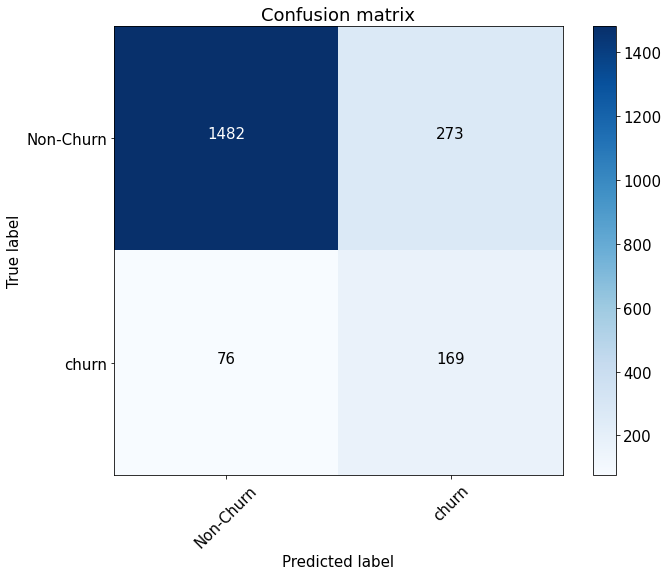

In [152]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
import itertools
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [153]:
roc_auc_score(y_test, preds)

0.8770788999360427

Разберись с tfidf, сделай домашку